## **Setup**
Call needed packages and load data filepath for Colab.

**Note:** This notebook ingests data downloaded from the Coronawhy dataverse via the notebook [`Dataverse-Colab-Connect.ipynb`](https://colab.research.google.com/drive/1R3QxPTEQNZzItAM_D5pT7n2Yk_JA4I4v#scrollTo=hq4gIQlylCJd).

In [0]:
#Point to file location
import os
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)
root = os.getcwd()
download_destination = 'gdrive/My Drive/COVID-19/data'
cwd = os.path.join(root, download_destination)
os.chdir(cwd)
print('Current working directory: ', os.getcwd())

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Current working directory:  /content/gdrive/My Drive/COVID-19/data


In [0]:
import spacy
import pandas as pd
import json

from __future__ import unicode_literals, print_function

import plac
import random
from pathlib import Path
from spacy.util import minibatch, compounding, decaying
# !python -m spacy download en_trf_bertbaseuncased_lg #bert model to update (not used currently)
# import en_trf_bertbaseuncased_lg
 

## **Step 1: Import results obtained from ElasticSearch**
Data can also be found in CoronaWhy's ElasticSearch.  You can download it via Brandon's notebook [here](https://colab.research.google.com/drive/1QWjwZDInL70O_yGwWdlsKqqTpEOLyRQ0#scrollTo=7h1nmpv1WCJH).

Data drawn from this location yields Elasticsearch results from the "More Like This" function.  The function evaluates sentences based on their similarity (BM25 score) to the query phrase ("sample size" in our case).  As I'm not medically well-versed, this method will hopefully +yield a variety of sentences containing information on sample sizes.  We'll then be able to annotate these sentences for the applicable data in the next step.

In [0]:
#Assumes you've downloaded the results to the google drive 
es_results = pd.read_csv('ES_results.csv')

#Drop 'Unnamed' columns
cols = [c for c in es_results.columns if c.lower() != 'unnamed']
es_results=es_results[cols]

len(es_results)

12870

In [0]:
es_results.head(3)

,Unnamed: 0,Unnamed: 0.1,cord_uid,language,sentence_id,section,subsection,sentence,lemma,UMLS,UMLS_IDS,translated,GGP,SO,TAXON,CHEBI,GO,CL,DNA,CELL_TYPE,CELL_LINE,RNA,PROTEIN,DISEASE,CHEMICAL,CANCER,ORGAN,TISSUE,ORGANISM,CELL,AMINO_ACID,GENE_OR_GENE_PRODUCT,SIMPLE_CHEMICAL,ANATOMICAL_SYSTEM,IMMATERIAL_ANATOMICAL_ENTITY,MULTI-TISSUE_STRUCTURE,DEVELOPING_ANATOMICAL_STRUCTURE,ORGANISM_SUBDIVISION,CELLULAR_COMPONENT,PATHOLOGICAL_FORMATION,ORGANISM_SUBSTANCE
0,0,0,4xavnaeb,en,4xavnaeb2924619,Enrollment,29,The Nomination Network shown in Fig. 4 highlig...,"['nomination', 'network', 'show', 'fig.', 'hig...","['Network', 'enrollment - coverage', 'Particip...","['C1882071', 'C3888021', 'C0679646', 'C0237401...",False,[],[],['individuals'],[],[],[],[],[],[],[],[],[],[],['Fig. 4'],[],[],['participants'],[],[],[],[],[],[],[],[],[],[],[],[]
1,1,1,5hrydciz,en,5hrydciz2213630,Patient screening and enrollment ::: Results,22,"Of all enrolled participants, 463 (Of all enro...","['enroll', 'participant', 'enroll', 'participa...","['Participant', 'Participant']","['C0679646', 'C0679646']",False,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],"['participants', 'participants']",[],[],[],[],[],[],[],[],[],[],[],[]
2,2,3,pjbr6yl2,da,pjbr6yl210184054,The National NeuroAIDS Tissue Consortium: Stat...,1018,\nEnrolled:\n,[],[],[],False,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]


## **Step 2: Annotate and Clean up Testing & Training Datasets**

I set Doccano up on a local server and used the GUI to annotate the dataset I pulled from our ElasticSearch.  Where a quantitative measure of sample size was not available, I identified the relative size ("small", "large", etc.), or the fact that it had not yet been calculated.  In this step, we'll import and clean up that data.

A setup document can be accessed [here](https://docs.google.com/document/d/1HfjhC0VEsIeDu0l6oV0vCzR6SxdvVwq6R5PRn0kWO00/edita).

As for cleanup, the data from Doccano doesn't exactly match the format mentioned on SpaCy's site, so we'll modify the annotated dataset to match. In the end, we want the data to look like this (entity slices are made up):
```
[('The sample size is 15.', {'entities': [(21, 25, 'SampleSize')]}), 
 ('With a sample size of 2000 and a dropout of 18', {'entities': [(21, 25, 'SampleSize'), (89, 91, 'Dropout']}),
```
Additionally, Spacy doesn't seem to like overlapping labels (e.g. `[(15, 18, label_1), (15, 18, label_2)]`, so we'll check for and eliminate those sentences to be sure they don't throw an error when we train our model in Step 3.

In [0]:
#Import data (need to read in with list comprehension because the json file generated by Doccano results in several dicts in a single json file (which can't otherwise be read))
filename = 'Sentence_Annotations.json1'
data = [json.loads(line) for line in open(filename, 'r')]
len(data)

20214

In [0]:
#Format data to match examples below
def extract_annotations(data):
    labeled_data = []
    unlabeled_data = []
    for d in data:
        if d['labels']:
            temp_list = [tuple(i) for i in d['labels']]
            labeled_data.append((d['text'], {'entities':temp_list})) 
        else:
            temp_list = [tuple(i) for i in d['labels']]
            unlabeled_data.append((d['text'], {'entities':temp_list})) 

    return labeled_data, unlabeled_data

LABELED_DATA, UNLABELED_DATA = extract_annotations(data)
print('LABELED_DATA: ', len(LABELED_DATA))
print('UNLABELED_DATA: ', len(UNLABELED_DATA))

LABELED_DATA:  1850
UNLABELED_DATA:  18364


In [0]:
#Check for duplicates among labeled/unlabeled datasets 
for labeled, unlabeled in zip(LABELED_DATA, UNLABELED_DATA):
    if labeled[0] in unlabeled[0]: #check sentence of one against sentence of another
        print(unlabeled)

In [0]:
#Visual verification (upon further notice, it seems that Doccano did not record fractured annotations (e.g. two parts of the same sentence annotated w/ the same label))
print('Total samples: ', len(LABELED_DATA), '\n')
LABELED_DATA[:10] #entity values may need to be in double list '[[...]]' instead of listed tuple '[(...)]'

Total samples:  1850 



[('Of all enrolled participants, 463 (Of all enrolled participants, 463',
  {'entities': [(30, 33, 'enrolled')]}),
 ('Of the 100 infants enrolled, 89 (the 100 infants enrolled, 89',
  {'entities': [(7, 10, 'enrolled')]}),
 ('Of the 2207 enrolled children, 379 (17%) were enrolled in the ICU.',
  {'entities': [(7, 11, 'enrolled')]}),
 ('Among the 150 enrolled CAP patients, 23 (150 enrolled CAP patients, 23',
  {'entities': [(10, 13, 'enrolled')]}),
 ('Among the 400,000 enrolled students, there are almost 4000 foreign students enrolled.',
  {'entities': [(10, 17, 'enrolled')]}),
 ('10 patients were planned to be enrolled and actually 11 patients were enrolled.',
  {'entities': [(53, 55, 'enrolled')]}),
 ('Of 381 children enrolled, 340 were enrolled through childcare centres and 41 through GP clinics.',
  {'entities': [(3, 7, 'enrolled')]}),
 ('Among those who enrolled, 262 (44.4%) participants enrolled as seeds and 328 (55.6%) as nominees.',
  {'entities': [(26, 30, 'enrolled'), (73, 77, 

In [0]:
#Visual check on labels
#note that indices are per sentence, not per entity, so you will see duplicates (this is intentional)
def print_indices(dataset, rows, printout=['all_info', 'labels only']):
    for idx, sent in enumerate(dataset[:rows]): 
        for entity in sent[1]['entities']:
            start = entity[0]
            end = entity[1]
            if printout=='all_info':
                print(idx, ": ", sent, '-->', sent[0][start:end]) #sentences, indices, tags, and entities
            elif printout=='labels':
                print(sent[0][start:end]) #just the labels

print_indices(LABELED_DATA, 10, 'all_info')

0 :  ('Of all enrolled participants, 463 (Of all enrolled participants, 463', {'entities': [(30, 33, 'enrolled')]}) --> 463
1 :  ('Of the 100 infants enrolled, 89 (the 100 infants enrolled, 89', {'entities': [(7, 10, 'enrolled')]}) --> 100
2 :  ('Of the 2207 enrolled children, 379 (17%) were enrolled in the ICU.', {'entities': [(7, 11, 'enrolled')]}) --> 2207
3 :  ('Among the 150 enrolled CAP patients, 23 (150 enrolled CAP patients, 23', {'entities': [(10, 13, 'enrolled')]}) --> 150
4 :  ('Among the 400,000 enrolled students, there are almost 4000 foreign students enrolled.', {'entities': [(10, 17, 'enrolled')]}) --> 400,000
5 :  ('10 patients were planned to be enrolled and actually 11 patients were enrolled.', {'entities': [(53, 55, 'enrolled')]}) --> 11
6 :  ('Of 381 children enrolled, 340 were enrolled through childcare centres and 41 through GP clinics.', {'entities': [(3, 7, 'enrolled')]}) --> 381 
7 :  ('Among those who enrolled, 262 (44.4%) participants enrolled as seeds and 32

      Label counts       
 -----------------------
enrolled :  1412
enrolled_add :  217
sample_size :  485
sample_size_add :  45
sample_size_subtract :  7
dropout :  28
enrolled_subtract :  8




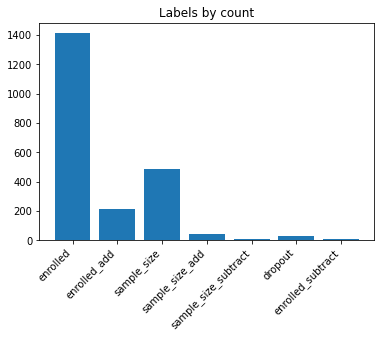

In [0]:
#Identify balance of labels

from collections import defaultdict
import matplotlib.pyplot as plt

def get_plot_label_counts(dataset):
    counts = defaultdict(int)

    for label in dataset:
        for entity in label[1]['entities']:
            counts[entity[2]] += 1

    #Print results
    print('      Label counts      ', '\n', '-----------------------')
    for label, count in counts.items():
        print(label, ': ', count)

    print('\n')

    #Plot results
    plt.title('Labels by count')
    plt.bar(counts.keys(), counts.values())
    plt.xticks(rotation=45, ha='right')

get_plot_label_counts(LABELED_DATA)

In [0]:
#Create a dataset with the first 485 enrolled and sample_size labels (so the dataset is balanced)


In [0]:
#keep only enrolled, enrolled_add, and sample_size (not enough data for other 3 labels)

wanted_labels = ['enrolled', 'sample_size']

MOD_LABELED_DATA = []

for sent, entities in LABELED_DATA:
    for entity in entities.values():
        labels_dict = {}
        new_ent_list = []
        for start, end, label in entity:
            if label in wanted_labels:
                new_ent = (start, end, label)
                new_ent_list.append(new_ent)
        labels_dict['entities'] = new_ent_list
        MOD_LABELED_DATA.append((sent, labels_dict))

In [0]:
#Train-test split

from sklearn.model_selection import train_test_split
TRAIN_DATA, TEST_DATA = train_test_split(MOD_LABELED_DATA, 
                                         train_size = 0.8,
                                         test_size = 0.2, 
                                         shuffle=True)
print('TRAIN_DATA: ', len(TRAIN_DATA))
print('TEST_DATA: ', len(TEST_DATA))

# get_plot_label_counts(TRAIN_DATA)

TRAIN_DATA:  1480
TEST_DATA:  370


In [0]:
#Check to see if entities overlap (will cause problem for SpaCy) --> just checks pairs in order.
for sent in TRAIN_DATA:
    if len(sent[1]['entities']) > 1:
        for idx, ent in enumerate(sent[1]['entities'][:-1]):
            if ent[:2] == sent[1]['entities'][idx+1][:2]:
                sent[1]['entities'].remove((ent)) #removes the sentence with duplicate entities
                print(sent) #prints the removed sentence(s)

In [0]:
#Remove a particularly problematic label
#The code above only removes labels whose ranges are identical, not those whose overlap (which is the problem with this label)
print('Pre-length: ', len(TRAIN_DATA))

#########Try this later to filter duplicate spans#########
# from spacy.util import filter_spans
# TRAIN_DATA = filter_spans(TRAIN_DATA)

TRAIN_DATA = [sent for sent in TRAIN_DATA if sent[1]['entities'] != [(96, 112, 'sample_size'), (96, 111, 'sample_size')]]
        
print('Post-length:' ,len(TRAIN_DATA))

Pre-length:  1480
Post-length: 1479


## **Step 3: Use the annotated data to train our spaCy NER model**

Initially, I thought I'd need to retrain a SciSpaCy model or whichever model Brandon used, however, I'm training a blank model here as it's not necessary at the moment that I have the other entities in the sentence identified for the training of this model (I think).

In [0]:
 def train(model, training_data, n_epochs=50):
    if model is not None:
       nlp = spacy.load(model)  # load existing spaCy model
       print("Loaded model '%s'" % model)
    else:
       nlp = spacy.blank("en")  # create blank Language class
       print("Created blank 'en' model")
       # create the built-in pipeline components and add them to the pipeline
       # nlp.create_pipe works for built-ins that are registered with spaCy
    if "ner" not in nlp.pipe_names:
      ner = nlp.create_pipe("ner")
      nlp.add_pipe(ner, last=True)
  # otherwise, get it so we can add labels
    else:
        ner = nlp.get_pipe("ner")

    # add labels
        for _, annotations in training_data:
            for ent in annotations.get("entities"):
                ner.add_label(ent[2])
  
        # get names of other pipes to disable them during training
        other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):  # only train NER
           # reset and initialize the weights randomly – but only if we're
            # training a new model
            if model is None:
               nlp.begin_training()
            for itn in range(n_epochs):
                random.shuffle(training_data)
                losses = {}
                # batch up the examples using spaCy's minibatch
                batch_size = compounding(2.0, 16.0, 1.001)
                batches = minibatch(training_data, size=batch_size)
                #decaying dropout rate
                dropout_rate = decaying(0.6, 0.2, 1e-4)
                for batch in batches:
                    texts, annotations = zip(*batch)
                    nlp.update(
                            texts,  # batch of texts
                            annotations,  # batch of annotations
                            drop=next(dropout_rate),  # dropout - make it harder to memorise data
                            losses=losses,
                        )
                print("epoch: {} Losses: {}".format(itn, str(losses)))
    return nlp

trained_model = train('en', TRAIN_DATA)

Loaded model 'en'
epoch: 0 Losses: {'ner': 21477.71919840506}
epoch: 1 Losses: {'ner': 19093.319854091853}
epoch: 2 Losses: {'ner': 18654.67068784911}
epoch: 3 Losses: {'ner': 18333.56606940135}
epoch: 4 Losses: {'ner': 18303.04884120304}
epoch: 5 Losses: {'ner': 18329.56747829169}
epoch: 6 Losses: {'ner': 18087.496675168564}
epoch: 7 Losses: {'ner': 18015.695999180083}
epoch: 8 Losses: {'ner': 17805.546393702738}
epoch: 9 Losses: {'ner': 17897.125770523584}
epoch: 10 Losses: {'ner': 17785.96334180083}
epoch: 11 Losses: {'ner': 17813.376352010586}
epoch: 12 Losses: {'ner': 17853.30268295965}
epoch: 13 Losses: {'ner': 17775.482486847148}
epoch: 14 Losses: {'ner': 17750.994947583924}
epoch: 15 Losses: {'ner': 17717.636233516325}
epoch: 16 Losses: {'ner': 17666.970086425426}
epoch: 17 Losses: {'ner': 17754.92422800645}
epoch: 18 Losses: {'ner': 17695.12609244447}
epoch: 19 Losses: {'ner': 17675.244720965624}
epoch: 20 Losses: {'ner': 17638.821592067194}
epoch: 21 Losses: {'ner': 17602.590

In [0]:
#Save the model to disk
trained_model.to_disk('./sentence_level_model_v4') 

#v1 is all labels
#v2 only includes labels for `enrolled`, `enrolled_add`, and `sample_size`
#v3 is `enrolled` and `sample_size` only

## **Step 4: Test our trained model**
Now to see how well our model generalizes by applying the model to the `TEST_DATA` dataset (our remaining annotated/labeled data).  We'll then generate statistics used to evaluate the results.

In [0]:
#Show model prediction examples
def evaluate_model(pretrained_model, test_data):
    labeled_sentences = []
    for test_instance in test_data:
        test_sentence, entities = test_instance        
        test_doc = pretrained_model(test_sentence)
        predicted_entities = [(ent.text, ent.label_) for ent in test_doc.ents]        
        original_entities = [(test_sentence[int(original_entity[0]): int(original_entity[1])], original_entity[2]) \
                             for original_entity in entities['entities']]
        labeled_sentences.append((test_sentence, dict({'entities':list(predicted_entities)})))

        print("--->" + test_sentence)
        print('original entities', original_entities)
        print('predicted entities', predicted_entities, '\n')        

    return labeled_sentences

labeledd_sentences = evaluate_model(trained_model, TEST_DATA)

--->Eighteen dogs with IBD and 20 healthy dogs were enrolled in the study.
original entities [('Eighteen', 'enrolled')]
predicted entities [('Eighteen', 'enrolled')] 

--->Fourteen healthy cats were enrolled in the study.
original entities [('Fourteen', 'enrolled')]
predicted entities [] 

--->Fifty-three children between 5 and 12 years-old were enrolled.
original entities [('Fifty-three', 'enrolled')]
predicted entities [('Fifty-three', 'enrolled')] 

--->Methods: A total of 260 children (140 patients with asthma and 120 control subjects) were enrolled in this study.
original entities [('260', 'enrolled')]
predicted entities [('260', 'enrolled')] 

--->Of the 88 healthy controls enrolled during the RSV season, 28 (31%
original entities []
predicted entities [('88', 'enrolled')] 

--->Finally, the small sample size of this study may limit the power to detect association factors with moderate strength.
original entities [('small', 'sample_size')]
predicted entities [('small', 'sample_si

In [0]:
from spacy.gold import GoldParse
from spacy.scorer import Scorer

def evaluate(ner_model, examples):
    scorer = Scorer()
    for input_, annot in examples:
        # print(input_, '--> ', annot)
        doc_gold_text = ner_model.make_doc(input_)
        gold = GoldParse(doc_gold_text, entities=annot['entities'])
        pred_value = ner_model(input_)
        scorer.score(pred_value, gold)
    return scorer.scores

#Evaluate model
results = evaluate(trained_model, TEST_DATA)

In [0]:
def format_results(results):
    scores_of_interest = {'ents_f':'Named entity F1 score', 
                        'ents_p':'Named entity precision', 
                        'ents_r':'Named entity recall', 
                        'ents_per_type':'Named entity score (breakdown)'
                        }

    score_abbreviation = {'p':'Precision',
                        'r':'Recall',
                        'f':'F1' 
                        }

    #Print out formatted statistics
    print('Overall statistics')
    print('------------------')
    for score_type, score in results.items():
        if (score_type in scores_of_interest) and (score_type!='ents_per_type'):
            print(scores_of_interest[score_type], ': {:.2f}%'.format(score))
        elif score_type=='ents_per_type':
            print('\n')
            print(scores_of_interest[score_type])
            print('------------------------------')
            breakdown = dict(score.items())
            for entity, values in breakdown.items():
                print(' '*4, entity)
                for sub_score_type, sub_score in values.items():
                    print(' '*8, score_abbreviation[sub_score_type], ': {:2f}%'.format(sub_score))
        else:
            continue

format_results(results)

Overall statistics
------------------
Named entity precision : 79.74%
Named entity recall : 68.32%
Named entity F1 score : 73.59%


Named entity score (breakdown)
------------------------------
     enrolled
         Precision : 78.776978%
         Recall : 81.412639%
         F1 : 80.073126%
     sample_size
         Precision : 87.878788%
         Recall : 30.851064%
         F1 : 45.669291%


# __Step 5: Run unlabeled data through the model__ #

And now we'll apply our model to our unlabeled data in order to identify sample sizes in this dataset!

In [0]:
trained_model = spacy.load('./sentence_level_model_v3')

In [0]:
#Find entities in unlabeled dataset
final_results = evaluate_model(trained_model, UNLABELED_DATA[:1000])

--->The Nomination Network shown in Fig. 4 highlights enrollment status (i.e., non-enrolled versus enrolled) and among enrolled participants, denotes whether individuals enrolled as seeds versus nominees.
original entities []
predicted entities [] 

--->Enrolled:
original entities []
predicted entities [] 

--->[{'text': 'were enrolled.
original entities []
predicted entities [] 

--->Although only 45% of eligible patients were enrolled, we found few differences in clinical characteristics between those who were enrolled compared to those who were not enrolled.
original entities []
predicted entities [] 

--->The age and sex of the enrolled children were comparable with those of children who were not enrolled.
original entities []
predicted entities [] 

--->Additionally, ILI patients were enrolled.
original entities []
predicted entities [] 

--->The mean (dogs were enrolled.
original entities []
predicted entities [] 

--->Two patients were enrolled twice.
original entities []
predic

In [0]:
#Calculate results statistics
numerator = 0
denominator = 0
for result in final_results:
    if len(result[1]['entities']) >= 1:
        numerator += 1
        denominator += 1
    else:
        denominator += 1

print('Entities have been found in {:.2f}% of sentences in the unlabeled dataset.'.format(numerator/denominator * 100))

Entities have been found in 43.00% of sentences in the unlabeled dataset.


## **Comparing annotated sentences in the same paper** 

Since we were annotating individual sentences, even with a good F1 score, I wanted to see some of the results as grouped by paper.  The following code does exactly that, in an effort to understand how many annotations are being made per paper on a subject such as `enrollment` counts.

In [0]:
#Keep only the columns we need
es_results = es_results.iloc[:,2:11]

In [0]:
#Transform our results into a dataframe for easy merging
f = pd.DataFrame([[k, v.values()] for k, v in final_results], columns=['sentence', 'entities'])
f.head()

,sentence,entities
0,The Nomination Network shown in Fig. 4 highlig...,([])
1,Enrolled:,([])
2,[{'text': 'were enrolled.,([])
3,Although only 45% of eligible patients were en...,([])
4,The age and sex of the enrolled children were ...,([])


In [0]:
#Merge annotated data with original dataframe (so as to get cord_uids for each sentence)
temp = es_results.merge(f, on='sentence', how='right')
print('Total values merged: ', temp.entities.value_counts().sum())

#drop sentences without entity labels
temp = temp.dropna(subset=['entities'])
print('Total non-null values: ', len(temp)) #"null" being different than "([])"

In [0]:
#drop entities with value '([])' (e.g. non-annotated sentences)
for idx, entity in enumerate(temp['entities']):
    entity = tuple(entity)[0]
    if not entity:
        temp.drop(idx, inplace=True)

print('Number of annotated sentences:', len(temp))

Number of annotated sentences 809


In [0]:
#keep only rows with more than one annotated sentence
temp = temp.groupby('cord_uid').filter(lambda x: len(x)>1) 
print('Multi-sentence length: ', len(temp))

#Sort the results and reset the indices
temp.sort_values(by='cord_uid', inplace=True)
temp.reset_index(drop=True, inplace=True)

#Display only the data that we need
# pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 999
temp[['cord_uid', 'sentence', 'entities']]

Multi-sentence length:  361


,cord_uid,sentence,entities
0,0aytlpyv,"Inpatients were enrolled and samples obtained within a median of 16 hours (interquartile range [IQR], 9–23 hours) of hospitalization.","([([, enrolled_1)])"
1,0aytlpyv,"From February 2015 to March 2017, we enrolled 150 children <2 years of age with RSV infection.","([(2015, enrolled_1), (150, enrolled_1)])"
2,0gzaonz9,Methods: All TB patients diagnosed at Sotiria and Sismanoglion Hospitals during an 18-month period were prospectively enrolled.,"([(18-month, enrolled_1)])"
3,0gzaonz9,One hundred four unselected and consecutive patients who underwent renal allograft transplantation in 2002 at Nantes Hospital were enrolled.,"([(One hundred four, enrolled_1)])"
4,0is6op3d,Methods: Sixty-two patients who had ferritin level data available at cGVHD diagnosis were enrolled into this study.,"([(Sixty-two, enrolled_1)])"
5,0is6op3d,"Results: 30 adult patients (median age 38 years, range 20-63, 13 female, 17 male) were enrolled in 7 centers.","([(30, enrolled_1)])"
6,0is6op3d,Methods: We enrolled 661 consecutive adult ALL patients who underwent transplantation from 1995 to 2015 in their first remission (CR1).,"([(661, enrolled_1)])"
7,0is6op3d,"Results: Fifty patients enrolled between 2011 and 2017 at 11 UK centres, the median age was 60 (19-70).","([(Fifty, enrolled_1)])"
8,0is6op3d,"Results: Of the enrolled 60 patients, there were 4 drop-outs due to medical reason or patientÂ´s will.","([(60, enrolled_1)])"
9,0is6op3d,"In total, 9 patients, 3 each for 3 doses of plerixafor, were enrolled and underwent allogeneic HSCT.","([(9, enrolled_1)])"


# **Future Option?: Read in data from Dataverse**

*Note, maybe this should be changed to MongoDB?

Guide to the end user:
1. Use read_big_json to read in a file. Pass the file path and the chunk size (default is 10000). Store the result as this result is a collection of the chunks
2. Write your processing function which consists of all operations you want to perform on your dataframe. Pass this function a single argument - the dataframe (chunk). Decorate it with @preprocess_chunk
3. Now, iterate over all chunks in the file read in through read_big_json and call your function on these chunks I have demonstrated these as below

PS: Currently this will only work for a JSON which is an array of objects. Other types are not supported yet

In [0]:
#Basic imports
!pip install ijson
import ijson
from itertools import islice, chain
#Creating my chunks generator
def chunks(iterable, size):
    iterator = iter(iterable)
    for first in iterator:
        yield chain([first], islice(iterator, size - 1))

#Reading in the JSON and creating chunks
def read_big_json(f, chunk_size=10000):
  obs = ijson.items(f, 'item')
  return chunks(obs,chunk_size)

#Wrapper for the above
def preprocess_chunk(original_fun):
  def wrapper(c):
    l=[]
    for el in c:
      l.append(el)
    df = pd.DataFrame(l)
    return original_fun(df)
  return wrapper

#My custom function is returndf which I've decorated with preprocess_chunk
@preprocess_chunk
def returndf(df):
  return df

In [0]:
#Reading in my chunks (file generation from notebook linked above)
f = open('v9text.json')
myfile = read_big_json(f,10000)

In [0]:
import pandas as pd
#Just checking the first 3 Dataframes that are created. Note: The file needs to be open for this to work
l=[]
c=0
for chunk in myfile:
    l.append(returndf(chunk))
    c+=1
    if (c==100):
        break

df = pd.concat(l)
df.info()